# Amazon Food Reviews
## Library Import


In [1]:
#Importing Library and setting environment path
import os
import sys
#set the path 
os.environ['SPARK_HOME'] = "C:/Spark"
sys.path.append("C:/Spark/bin")
sys.path.append("C:/Spark/python")
sys.path.append("C:/Spark/python/pyspark")
sys.path.append("C:/Spark/python/pyspark/lib")
sys.path.append("C:/Spark/python/pyspark/lib/pyspark.zip")
sys.path.append("C:/Spark/python/pyspark/lib/py4j-0.10.3-src.zip")
sys.path.append("C:/Program Files/Java/jre1.8.0_111/bin")
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize   

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import SQLContext
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, NaiveBayes, GBTClassifier
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel,LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from vaderSentiment import vaderSentiment
from pyspark.ml.feature import NGram
import matplotlib
matplotlib.style.use('ggplot')

## Import file

In [2]:
#Importing data set and making a SparkSQLDataFrame
sc = SparkContext("local","test")
sqlContext = SQLContext(sc)
data = sc.textFile('file:///D:/Carlson/Fall/6330 Harvesting Big Data/FinalProject/Reviews_new.csv').map(lambda x: x.split('\t')).toDF()
data = data.selectExpr("_1 as Id", "_2 as ProductId", "_3 as UserId", "_4 as ProfileName", "_5 as HelpfulnessNumerator", "_6 as HelpfulnessDenominator","_7 as Score","_8 as Time","_9 as Summary","_10 as Text")

## Exploration and Manipulation

In [3]:
#Printing Schema
data.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [4]:
#Checking some values
data.head(5)

[Row(Id=u'1', ProductId=u'B001E4KFG0', UserId=u'A3SGXH7AUHU8GW', ProfileName=u'delmartian', HelpfulnessNumerator=u'1', HelpfulnessDenominator=u'1', Score=u'5', Time=u'1303862400', Summary=u'Good Quality Dog Food', Text=u'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'),
 Row(Id=u'2', ProductId=u'B00813GRG4', UserId=u'A1D87F6ZCVE5NK', ProfileName=u'dll pa', HelpfulnessNumerator=u'0', HelpfulnessDenominator=u'0', Score=u'1', Time=u'1346976000', Summary=u'Not as Advertised', Text=u'"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."'),
 Row(Id=u'3', ProductId=u'B000LQOCH0', UserId=u'ABXLMWJIXXAIN', ProfileName=u'"Natalia Corres ""Natal

In [5]:
#Counting number of rows
data.count()

568454

In [6]:
#Filtering out records with rating = 3
messages = data.filter(data.Score != "3").select('Score','Text')
messages = messages.withColumn("Score", messages["Score"].cast(DoubleType()))

#Converting score to a binary positive - 1 and negative - 0 feature
def toBinary(score):
    if score >= 3: return 1
    else: return 0
udfScoretoBinary=udf(toBinary, StringType())

messages = messages.withColumn("Target", udfScoretoBinary("Score")).select('Text','Target')
messages.show(2)

+--------------------+------+
|                Text|Target|
+--------------------+------+
|I have bought sev...|     1|
|"Product arrived ...|     0|
+--------------------+------+
only showing top 2 rows



In [42]:
messages.count()

525814

### Sentiment Analysis using VaderSentiment library

In [6]:
sentiment = messages.rdd.map(lambda x: [x[1],vaderSentiment.SentimentIntensityAnalyzer().polarity_scores(x[0][0:140])])

In [7]:
sentiment.cache()
sentiment.take(2)

[[u'1', {'compound': 0.7902, 'neg': 0.0, 'neu': 0.734, 'pos': 0.266}],
 [u'0', {'compound': -0.1027, 'neg': 0.104, 'neu': 0.808, 'pos': 0.088}]]

In [9]:
sentiment_DF = sentiment.map(lambda x: (x[0],x[1]['compound'],x[1]['neg'],x[1]['neu'],x[1]['pos'])).toDF()

In [ ]:
sentiment_pandas = sentiment_DF.toPandas()

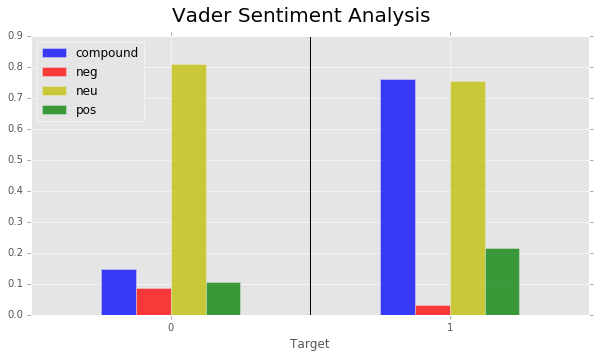

In [83]:
# importing the data
sentiment_pandas = pd.read_csv('D:/Carlson/Fall/6330 Harvesting Big Data/FinalProject/Reviews.csv')

#Sampling
sentiment_pandas = sentiment_pandas.sample(n = 20000)

#Calculating sentiments
sentiment_pandas_1 = pd.DataFrame(list(sentiment_pandas.Text.apply(lambda x: vaderSentiment.SentimentIntensityAnalyzer().polarity_scores(x))))

#Ratings processing
sentiment_pandas_1['Target'] = list(sentiment_pandas['Score'])
sentiment_pandas_1 = sentiment_pandas_1.ix[sentiment_pandas_1.Target != 3,]
sentiment_pandas_1.Target = sentiment_pandas_1.Target.apply(lambda x: 1 if x>3 else 0)

# Plotting the postive and negative sentiments average values from Vader Sentiment library
plt.rcParams['figure.figsize'] = (10.0, 5.0)
sentiment_pandas_1.groupby('Target').mean().plot(kind='bar',alpha=0.75, rot=0,color = ['b','r','y','g']);
plt.suptitle('Vader Sentiment Analysis', fontsize=20)
plt.axvline(0.5, color='black');

### Lower Text

In [7]:
#Lower casing the text
def lower_text(line):
    return line.lower()
udflower_text=udf(lower_text, StringType())
messages_lower = messages.withColumn("text_lower", udflower_text("Text")).select('text_lower','Target')

In [6]:
#Showing the result
messages_lower.show(2)

+--------------------+------+
|          text_lower|Target|
+--------------------+------+
|i have bought sev...|     1|
|"product arrived ...|     0|
+--------------------+------+
only showing top 2 rows



### Tokenize

In [8]:
#Tokenizing the document
tokenizer = Tokenizer(inputCol="text_lower", outputCol="words")
wordsDataFrame = tokenizer.transform(messages_lower)
for words_label in wordsDataFrame.select("words", "Target").take(3):
    print(words_label)

Row(words=[u'i', u'have', u'bought', u'several', u'of', u'the', u'vitality', u'canned', u'dog', u'food', u'products', u'and', u'have', u'found', u'them', u'all', u'to', u'be', u'of', u'good', u'quality.', u'the', u'product', u'looks', u'more', u'like', u'a', u'stew', u'than', u'a', u'processed', u'meat', u'and', u'it', u'smells', u'better.', u'my', u'labrador', u'is', u'finicky', u'and', u'she', u'appreciates', u'this', u'product', u'better', u'than', u'', u'most.'], Target=u'1')
Row(words=[u'"product', u'arrived', u'labeled', u'as', u'jumbo', u'salted', u'peanuts...the', u'peanuts', u'were', u'actually', u'small', u'sized', u'unsalted.', u'not', u'sure', u'if', u'this', u'was', u'an', u'error', u'or', u'if', u'the', u'vendor', u'intended', u'to', u'represent', u'the', u'product', u'as', u'""jumbo""."'], Target=u'0')
Row(words=[u'"this', u'is', u'a', u'confection', u'that', u'has', u'been', u'around', u'a', u'few', u'centuries.', u'', u'it', u'is', u'a', u'light,', u'pillowy', u'citrus

### Stopword Removal

In [9]:
# Removing stopwords
remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")
wordsDataFrame1 = remover.transform(wordsDataFrame).select("Target","words_filtered")

In [88]:
#Displaying the resultant dataframe
wordsDataFrame1.show(2)

+------+--------------------+
|Target|      words_filtered|
+------+--------------------+
|     1|[bought, several,...|
|     0|["product, arrive...|
+------+--------------------+
only showing top 2 rows



### Stemming

In [10]:
# Stemming the text
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

In [11]:
def stem_text(tokens):
    stems = stem_tokens(tokens)
    return ' '.join(stems)

udfstem_text=udf(stem_text, StringType())
wordsDataFrame2 = wordsDataFrame1.withColumn("final_text", udfstem_text("words_filtered")).select('final_text','Target')

In [12]:
# Caching the RDD
wordsDataFrame2.cache()
#Renaming features for modeling
training = wordsDataFrame2.selectExpr("final_text as text", "Target as label")
training = training.withColumn("label", training["label"].cast(DoubleType()))

In [12]:
training.take(2)

[Row(text=u'bought sever vital can dog food product found good quality. product look like stew process meat smell better. labrador finicki appreci product better  most.', label=1.0),
 Row(text=u'"product arriv label jumbo salt peanuts...th peanut actual small size unsalted. sure error vendor intend repres product ""jumbo""."', label=0.0)]

### TF - IDF Pilpeling

In [54]:
#Creating pipeline for Tokenizing, TF - IDF and Logistic Regression Model
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# Training the model
model = pipeline.fit(training)

In [53]:
#Predicing Output
prediction = model.transform(training)

In [54]:
#Printing Schema of Prediction Dataset
prediction.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashing: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [55]:
#Printing Error Rate on Training set :-
print "Error rate is: {0}".format(prediction.rdd.map(lambda line: abs(line[1] - line[7])).reduce(lambda x,y:x+y) / float(prediction.count()))

Error rate is: 0.0218858036078


### Logistic Regression with 5 fold cross validation

In [69]:
#Creating pipeline for Tokenizing, TF - IDF and Logistic Regression Model
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# Training the model
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01,.001,1,100,200]) \
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator()  ,
                          numFolds=5)
model = crossval.fit(training)
model.avgMetrics

[0.9561484487899199,
 0.9471773117678483,
 0.9401087396786587,
 0.9519581876966348,
 0.9062738138953563,
 0.9016377225429577]

### Naive Bayes

In [11]:
#Creating pipeline for Tokenizing, TF - IDF and Logistic Regression Model
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])
# Training the model
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [1,2]).build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator()  ,
                          numFolds=5)
model = crossval.fit(training)
model.avgMetrics

[0.5750640256303141, 0.57489283866258]

### DT

## Word Cloud 

In [14]:
wordclouddata = wordsDataFrame2.rdd.map(lambda x: (x[1],x[0])).flatMapValues(lambda x: x.split(' ')).flatMapValues(lambda x: x.split('.')).toDF()
wordclouddata = wordclouddata.selectExpr("_1 as Label","_2 as word")
wordclouddata.registerTempTable("words")

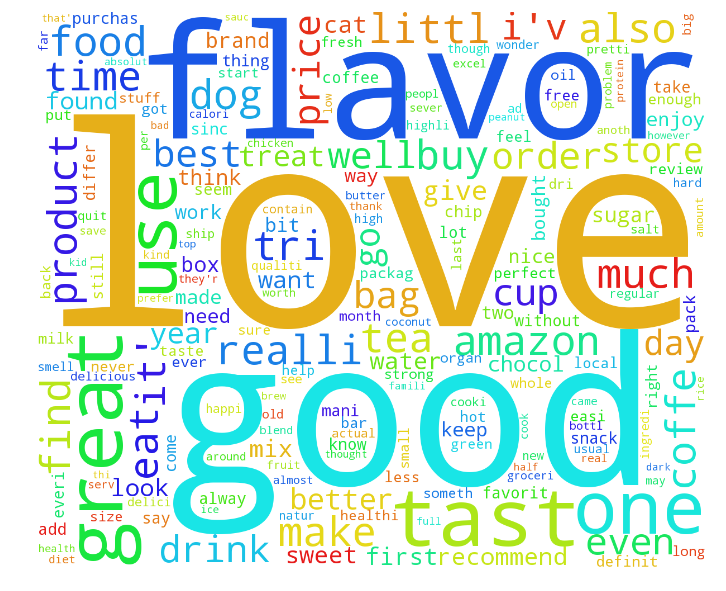

In [39]:
pos_words = sqlContext.sql(" SELECT word,round(count(Label) / 100) as cnt from words where Label = 1 group by word order by cnt desc").take(1000)

x = ""
for i in pos_words:
        if (i[0] == "<br") | (i[0] == "/><br"):
            pass
        else:
            for a in range(int(i[1])):
                if i[0] == "":
                    pass
                else:
                    x = x +" " +  i[0]
                    
plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(x)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

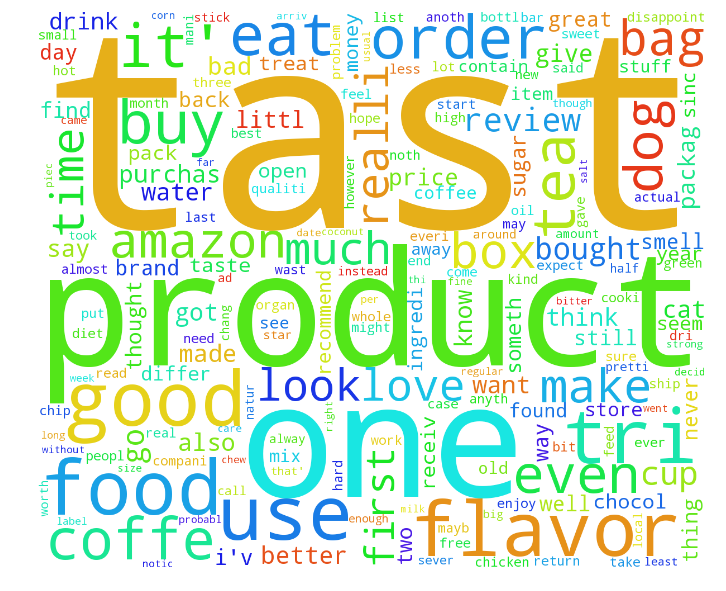

In [41]:
neg_words = sqlContext.sql(" SELECT word,round(count(Label) / 100) as cnt from words where Label = 0 group by word order by cnt desc").take(1000)

x = ""
for i in neg_words:
        if (i[0] == "<br") | (i[0] == "/><br"):
            pass
        else:
            for a in range(int(i[1])):
                if i[0] == "":
                    pass
                else:
                    x = x +" " +  i[0]
                    
plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(x)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Bi gram

In [38]:
wordsDataFrame_1 = wordsDataFrame1.filter(wordsDataFrame1.Target == 1)
wordsDataFrame_0 = wordsDataFrame1.filter(wordsDataFrame1.Target == 0)

In [39]:
wordsDataFrame_1.take(2)

[Row(Target=u'1', words_filtered=[u'bought', u'several', u'vitality', u'canned', u'dog', u'food', u'products', u'found', u'good', u'quality.', u'product', u'looks', u'like', u'stew', u'processed', u'meat', u'smells', u'better.', u'labrador', u'finicky', u'appreciates', u'product', u'better', u'', u'most.']),
 Row(Target=u'1', words_filtered=[u'"this', u'confection', u'around', u'centuries.', u'', u'light,', u'pillowy', u'citrus', u'gelatin', u'nuts', u'-', u'case', u'filberts.', u'cut', u'tiny', u'squares', u'liberally', u'coated', u'powdered', u'sugar.', u'', u'tiny', u'mouthful', u'heaven.', u'', u'chewy,', u'flavorful.', u'', u'highly', u'recommend', u'yummy', u'treat.', u'', u'familiar', u'story', u'c.s.', u"lewis'", u'""the', u'lion,', u'witch,', u'wardrobe""', u'-', u'treat', u'seduces', u'edmund', u'selling', u'brother', u'sisters', u'witch."'])]

In [40]:
ngram = NGram(n=2, inputCol="words_filtered", outputCol="nGrams")
ngram.transform(wordsDataFrame_1).head()

bigrammed = ngram.transform(wordsDataFrame_1)

In [41]:
bigrams = bigrammed.rdd.map(lambda line:line[2])
bigrams.take(2)

[[u'bought several',
  u'several vitality',
  u'vitality canned',
  u'canned dog',
  u'dog food',
  u'food products',
  u'products found',
  u'found good',
  u'good quality.',
  u'quality. product',
  u'product looks',
  u'looks like',
  u'like stew',
  u'stew processed',
  u'processed meat',
  u'meat smells',
  u'smells better.',
  u'better. labrador',
  u'labrador finicky',
  u'finicky appreciates',
  u'appreciates product',
  u'product better',
  u'better ',
  u' most.'],
 [u'"this confection',
  u'confection around',
  u'around centuries.',
  u'centuries. ',
  u' light,',
  u'light, pillowy',
  u'pillowy citrus',
  u'citrus gelatin',
  u'gelatin nuts',
  u'nuts -',
  u'- case',
  u'case filberts.',
  u'filberts. cut',
  u'cut tiny',
  u'tiny squares',
  u'squares liberally',
  u'liberally coated',
  u'coated powdered',
  u'powdered sugar.',
  u'sugar. ',
  u' tiny',
  u'tiny mouthful',
  u'mouthful heaven.',
  u'heaven. ',
  u' chewy,',
  u'chewy, flavorful.',
  u'flavorful. ',
  u

In [16]:
all_bigrams = bigrams.flatMap(lambda list:[x for x in list])
top1000_bigrams_1 = all_bigrams.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).takeOrdered(1000, key=lambda x: -x[1])
bigrammed_0 = ngram.transform(wordsDataFrame_0)
bigrams_0 = bigrammed_0.rdd.map(lambda line:line[2])
all_bigrams_0 = bigrams_0.flatMap(lambda list:[x for x in list])
top1000_bigrams_0 = all_bigrams_0.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).takeOrdered(1000, key=lambda x: -x[1])

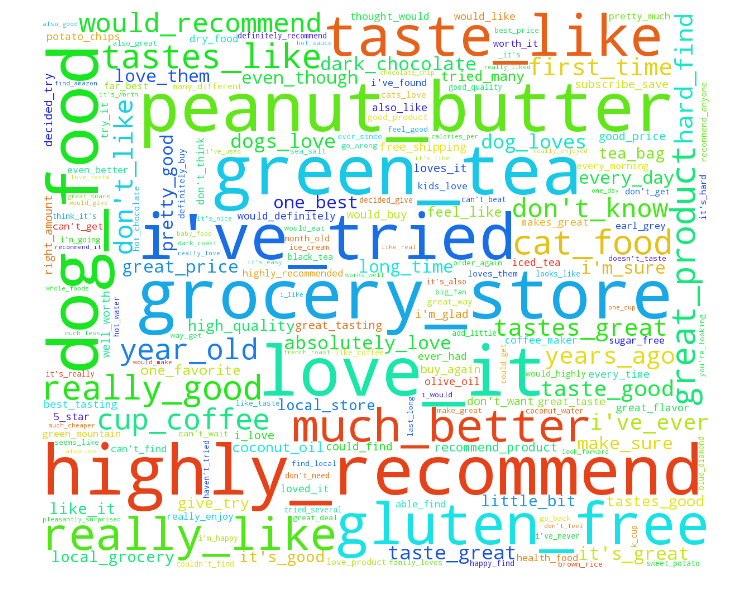

In [55]:
x1 = sc.parallelize(top1000_bigrams_1)
x2 = x1.map(lambda x:(x[0].replace(' ','_'), x[1]))
wordcloud_1 = x2.toDF()
wordcloud_1 = wordcloud_1.selectExpr("_1 as BiGram","_2 as freq")
wordcloud_1.registerTempTable("positive")


pos_words = sqlContext.sql(" SELECT BiGram, round(freq)/100 as cnt from positive where BiGram NOT LIKE '%/><br%' OR BiGram NOT LIKE '_%' OR BiGram NOT LIKE '%_' order by cnt desc")
pos_words1 = pos_words.collect()
x = ""
for i in pos_words1:
    if i[0][0] == "_":
        pass
    elif i[0][len(i[0])-1] == "_":
        pass
    else:
        for a in range(int(i[1])):
            x = x + " " +  str(i[0])

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(x)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

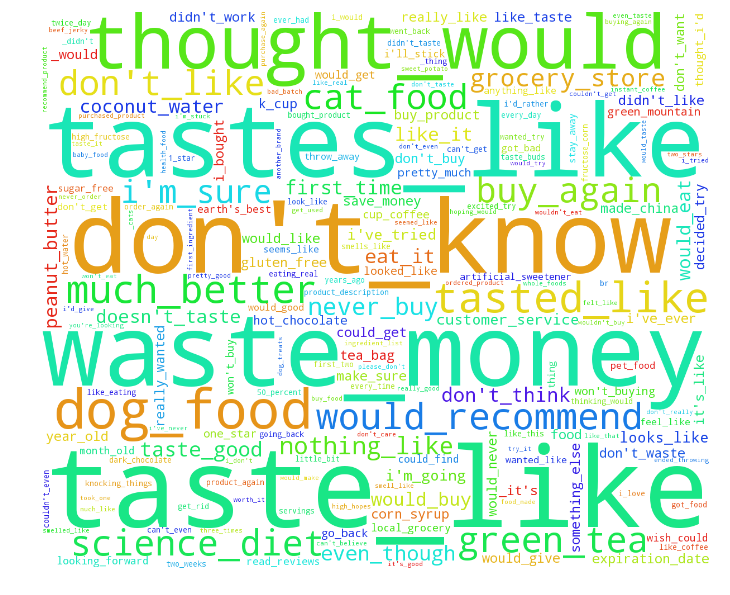

In [53]:
x1 = sc.parallelize(top1000_bigrams_0)
x2 = x1.map(lambda x:(x[0].replace(' ','_'), x[1]))
wordcloud_0 = x2.toDF()
wordcloud_0 = wordcloud_0.selectExpr("_1 as BiGram","_2 as freq")
wordcloud_0.registerTempTable("negative")


neg_words = sqlContext.sql(" SELECT BiGram, round(freq)/100 as cnt from negative where BiGram NOT LIKE '%/><br%' OR BiGram NOT LIKE '_%' OR BiGram NOT LIKE '%_' order by cnt desc")
neg_words0 = neg_words.collect()
y = ""
for i in neg_words0:
    if i[0][0] == "_":
        pass
    elif i[0][len(i[0])-1] == "_":
        pass
    else:
        for a in range(int(i[1])):
            y = y + " " +  str(i[0])

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(y)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()